In [1]:
import numpy as np
import scipy.interpolate as interpolate
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import pickle

In [2]:
def load_data(filename):
    """Load and return data saved to disc with the function `save_data`."""
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    return data

filename = 'data_square/data_ising_square_largeL.pkl'
data = load_data(filename)

**(a)**

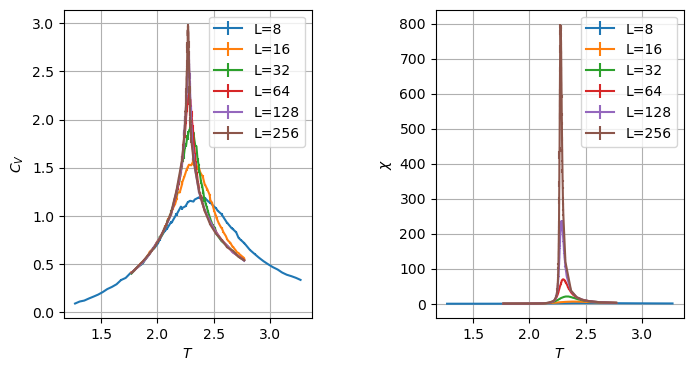

In [3]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 4))
for L in data['Ls']:
    ax0.errorbar(data[L]['Ts'], data[L]['C'][:, 0], data[L]['C'][:, 1], label='L={L:d}'.format(L=L))
    ax1.errorbar(data[L]['Ts'], data[L]['chi'][:, 0], data[L]['chi'][:, 1], label='L={L:d}'.format(L=L))
ax0.set_xlabel("$T$"), ax1.set_xlabel("$T$"), ax0.set_ylabel("$C_{V}$"), ax1.set_ylabel("$\chi$"), ax0.grid(), ax1.grid(), ax0.legend(), ax1.legend();
fig.subplots_adjust(wspace=0.5)

**(b)**

critical temperatur T_c = 2.267


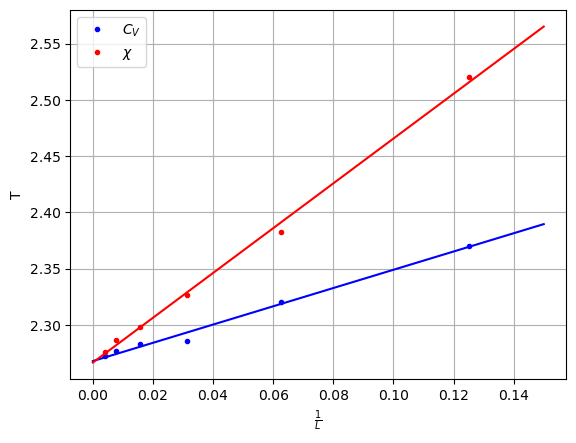

In [4]:
one_over_Ls, T_max_Cs, T_max_chis = [], [], []
for L in data['Ls']:
    one_over_Ls.append(1/L)
    T_max_Cs.append( data[L]['Ts'][np.argmax(data[L]['C'][:, 0])] )
    T_max_chis.append( data[L]['Ts'][np.argmax(data[L]['chi'][:, 0])] )

poly_C = np.poly1d(np.polyfit(one_over_Ls, T_max_Cs, deg=1))
poly_chi = np.poly1d(np.polyfit(one_over_Ls, T_max_chis, deg=1))
x = np.linspace(0, 0.15, 100)

fig, ax = plt.subplots(1, 1)
ax.plot(one_over_Ls, T_max_Cs, '.', color='b', label='$C_{V}$') 
ax.plot(one_over_Ls, T_max_chis, '.', color='r', label='$\chi$')
ax.plot(x, poly_C(x), '-', color='b')
ax.plot(x, poly_chi(x), '-', color='r')
ax.set_xlabel("$\\frac{1}{L}$"), ax.set_ylabel("T"), ax.grid(), ax.legend();
fig.subplots_adjust(wspace=0.5)

T_c = (poly_C(0) + poly_chi(0)) / 2
print("critical temperatur T_c = %.3f" %(T_c))

**(c)**

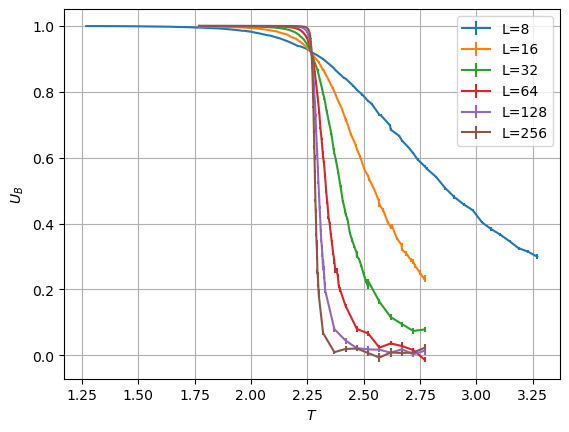

In [5]:
fig, ax = plt.subplots(1, 1,)
for L in data['Ls']:
    ax.errorbar(data[L]['Ts'], data[L]['UB'][:, 0], data[L]['UB'][:, 1], label='L={L:d}'.format(L=L))
ax.set_xlabel("$T$"), ax.set_ylabel("C"), ax.set_ylabel("$U_{B}$"), ax.grid(), ax.legend();

In [6]:
def interpolate_crossings(data1, data2, T_range:(int, int)=(2.1, 2.3)):
    """Linearly interpolate between data points and find intersections of UB(T) fucntions corresponding to pairs (L, 2L)"""

    y1, x1 = data1['UB'][:,0], data1['Ts']
    y2, x2 = data2['UB'][:,0], data2['Ts']

    # Only use points near the crossing
    filter_1 = (T_range[0] < x1) & (x1 < T_range[1])
    filter_2 = (T_range[0] < x2) & (x2 < T_range[1])
    x1, x2 = x1[filter_1], x2[filter_2]
    y1, y2 = y1[filter_1], y2[filter_2]

    # Linear interpolators
    f1 = interpolate.interp1d(x1, y1, fill_value='extrapolate')
    f2 = interpolate.interp1d(x2, y2, fill_value='extrapolate')

    # Specify starting estimates and range of valid solutions
    xs = np.unique(np.concatenate((x1,x2)))
    xmin = np.min(xs)
    xmax = np.max(xs)

    crossings = []
    for x in xs:
        xsol, = optimize.fsolve(lambda x: f1(x)-f2(x), x)

        if (xmin<=xsol<=xmax and np.isclose(f1(xsol), f2(xsol)) and not any(np.isclose(xsol, crossings))):
            crossings.append(xsol) # Should be only one solution, but more are possible if simulated data is to noisy
        
    return crossings


L_to_Tcrossings = {}
for L in data['Ls'][:-1]:
    Tcrossings = interpolate_crossings(data[L], data[2*L])
    assert len(Tcrossings)==1, "Found more than one crossing corresponding to system sizes (%d, %d). Get rid of noise."%(L, 2*L)
    L_to_Tcrossings[L] = Tcrossings[0]

print(L_to_Tcrossings)

/Users/danielortmann/miniconda3/envs/cmb/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/danielortmann/miniconda3/envs/cmb/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


{8: 2.2628390993932563, 16: 2.2710546984717683, 32: 2.2682530373224776, 64: 2.268334557270438, 128: 2.2693924314808798}


critical temperatur T_c = 2.268


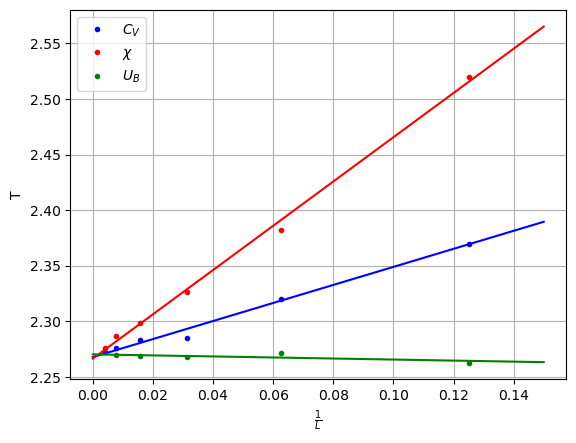

In [7]:
# Add Ts from UB crossings to (b)
one_over_Ls_from_crossings, T_crossings = 1/np.array(list(L_to_Tcrossings.keys())), list(L_to_Tcrossings.values())

one_over_Ls, T_max_Cs, T_max_chis = [], [], []
for L in data['Ls']:
    one_over_Ls.append(1/L)
    T_max_Cs.append( data[L]['Ts'][np.argmax(data[L]['C'][:, 0])] )
    T_max_chis.append( data[L]['Ts'][np.argmax(data[L]['chi'][:, 0])] )

poly_C = np.poly1d(np.polyfit(one_over_Ls, T_max_Cs, deg=1))
poly_chi = np.poly1d(np.polyfit(one_over_Ls, T_max_chis, deg=1))
poly_UB = np.poly1d(np.polyfit(one_over_Ls_from_crossings, T_crossings, deg=1))
x = np.linspace(0, 0.15, 100)

fig, ax = plt.subplots(1, 1)
ax.plot(one_over_Ls, T_max_Cs, '.', color='b', label='$C_{V}$') 
ax.plot(one_over_Ls, T_max_chis, '.', color='r', label='$\chi$')
ax.plot(one_over_Ls_from_crossings, T_crossings, '.', color='g', label='$U_{B}$')
ax.plot(x, poly_C(x), '-', color='b')
ax.plot(x, poly_chi(x), '-', color='r')
ax.plot(x, poly_UB(x), '-', color='g')
ax.set_xlabel("$\\frac{1}{L}$"), ax.set_ylabel("T"), ax.grid(), ax.legend();
fig.subplots_adjust(wspace=0.5)

T_c = (poly_C(0) + poly_chi(0) + poly_UB(0)) / 3
print("critical temperatur T_c = %.3f" %(T_c))

**(d)**

In [8]:
max_Cs, max_chis = [], []
for L in data['Ls']:
    max_Cs.append(np.max(data[L]['C'][:, 0]))
    max_chis.append(np.max(data[L]['chi'][:, 0]))

α_over_ν, _ = np.polyfit(np.log(data['Ls']), np.log(max_Cs), deg=1)
γ_over_ν, _ = np.polyfit(np.log(data['Ls']), np.log(max_chis), deg=1)

print(α_over_ν, γ_over_ν)

0.26087457372818723 1.7627081942228464


**(e)**

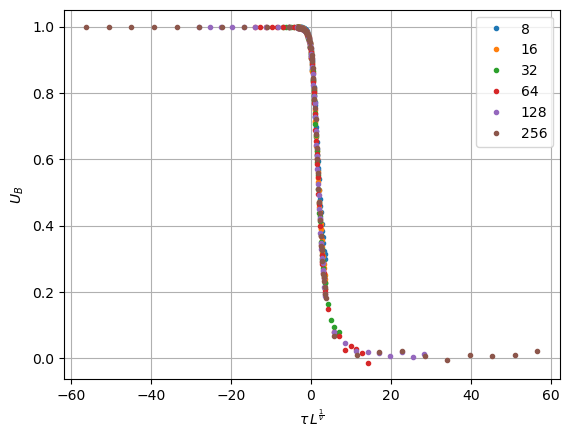

In [9]:
fig, ax = plt.subplots(1, 1)
ν = 1
for L in data['Ls']:
    ax.plot( (data[L]['Ts'] / T_c - 1) * L**(1/ν), data[L]['UB'][:,0], '.', label='%d'%(L))
ax.set_xlabel("$\\tau\,L^{\\frac{1}{ν}}$"), ax.set_ylabel("$U_{B}$"), ax.grid(), ax.legend();

Therefore, $\nu = 1$.

**(f)**

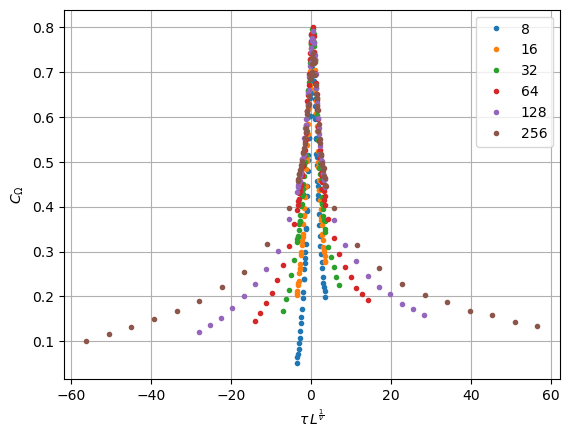

In [10]:
fig, ax = plt.subplots(1, 1)
α = 0.25
for L in data['Ls']:
    ax.plot( (data[L]['Ts'] / T_c - 1) * L**(1/ν), data[L]['C'][:,0] / L**(α/ν), '.', label='%d'%(L))
ax.set_xlabel("$\\tau\,L^{\\frac{1}{ν}}$"), ax.set_ylabel("$C_{Ω}$"), ax.grid(), ax.legend();

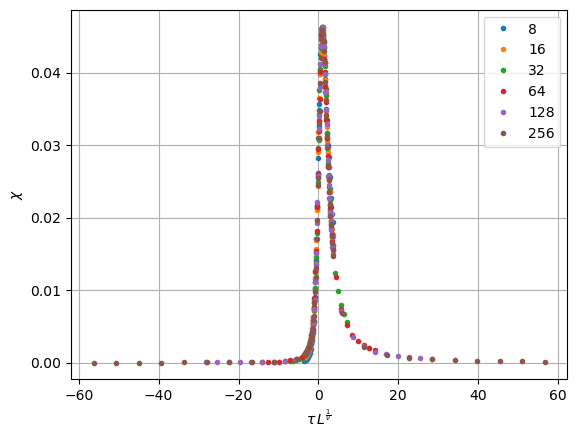

In [11]:
fig, ax = plt.subplots(1, 1)
γ = 1.76
for L in data['Ls']:
    ax.plot( (data[L]['Ts'] / T_c - 1) * L**(1/ν), data[L]['chi'][:,0] / L**(γ/ν), '.', label='%d'%(L))
ax.set_xlabel("$\\tau\,L^{\\frac{1}{ν}}$"), ax.set_ylabel("$\chi$"), ax.grid(), ax.legend();

In [12]:
α, ν, γ

(0.25, 1, 1.76)